Image shape: (645, 1024)
Binary image shape: (645, 1024)


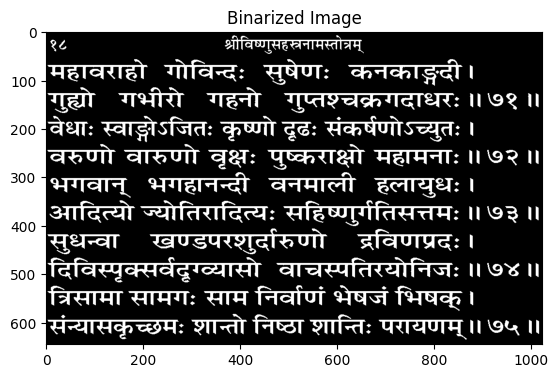

Horizontal histogram length: 645


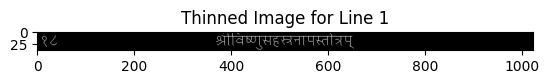

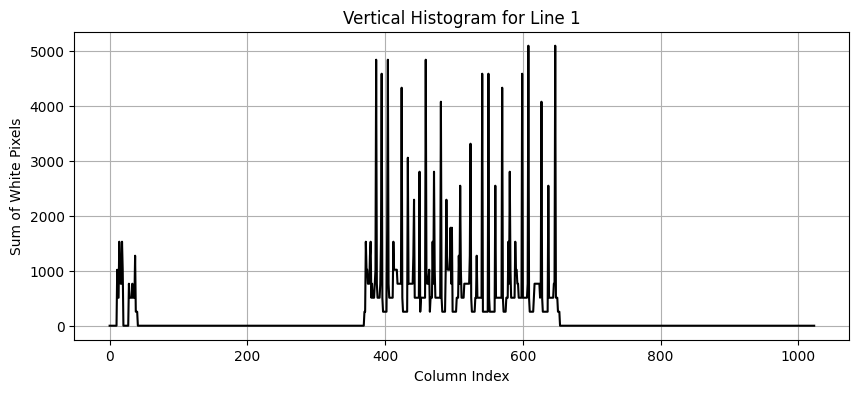

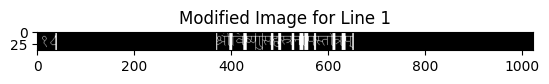

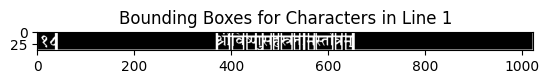

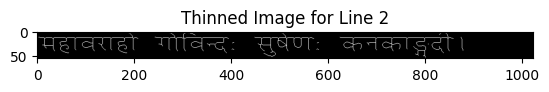

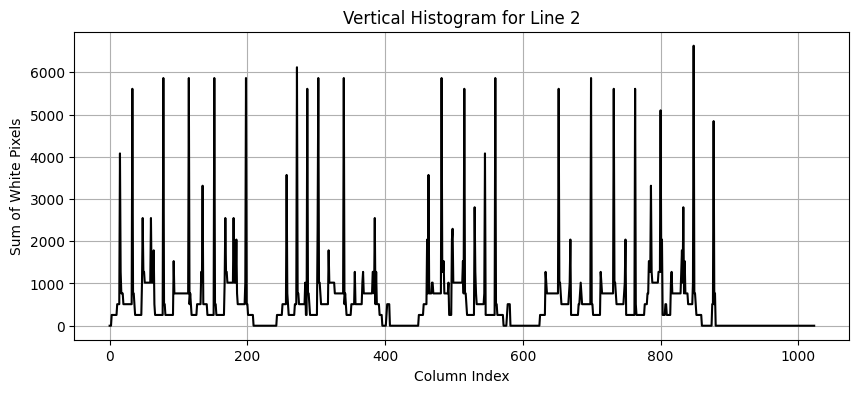

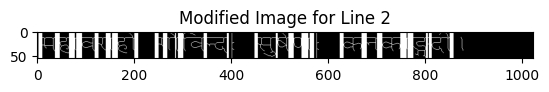

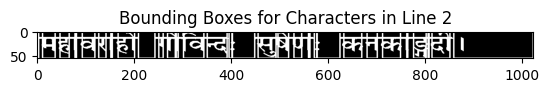

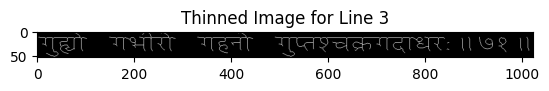

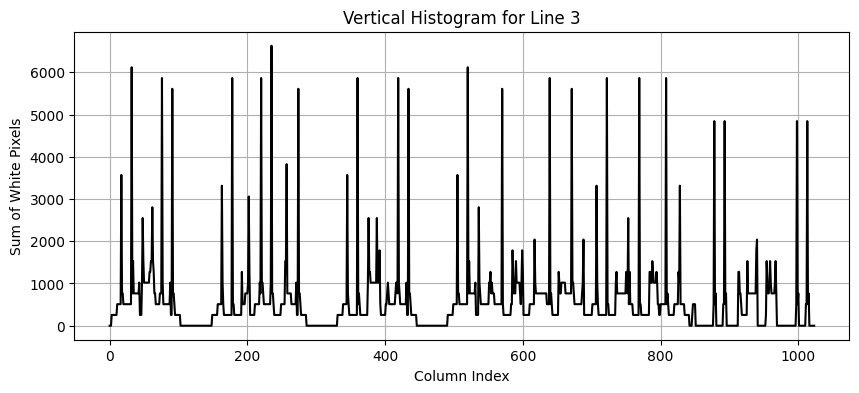

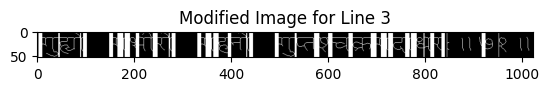

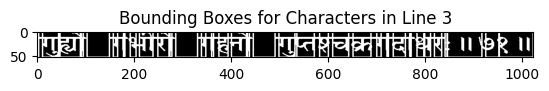

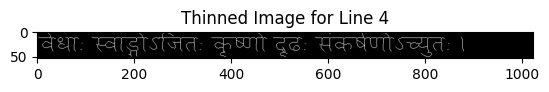

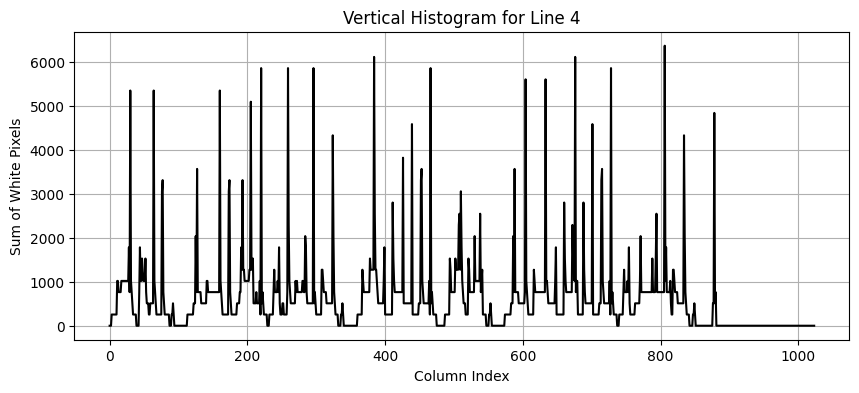

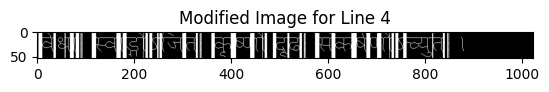

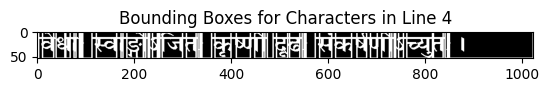

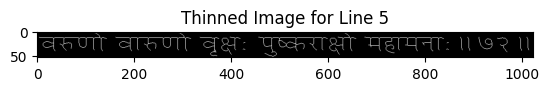

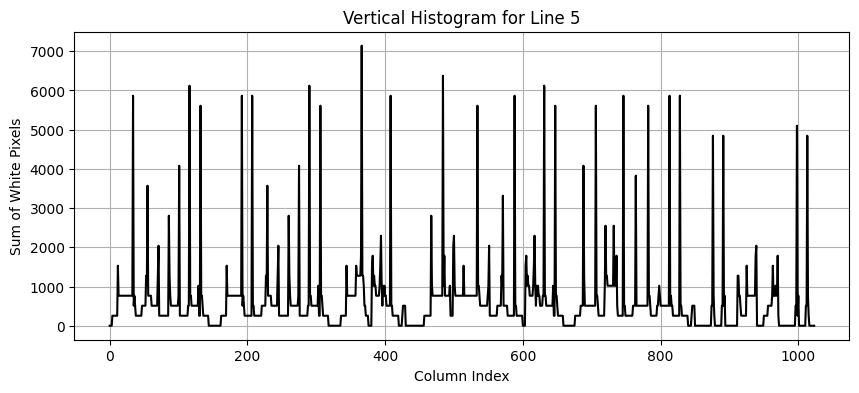

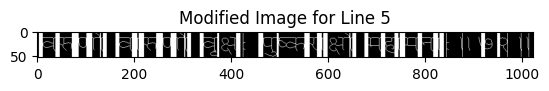

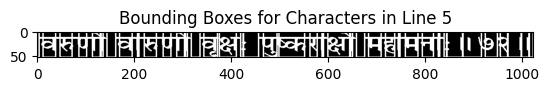

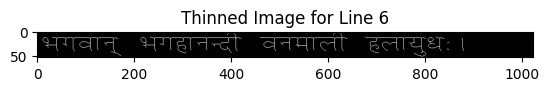

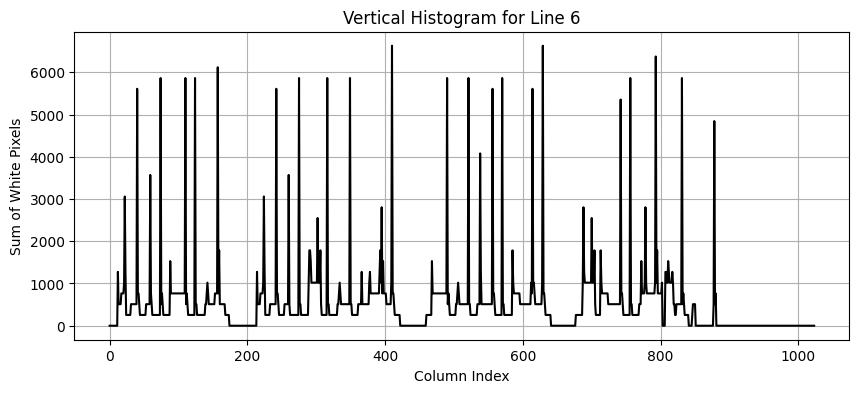

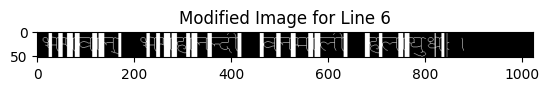

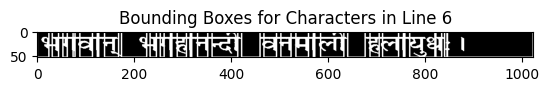

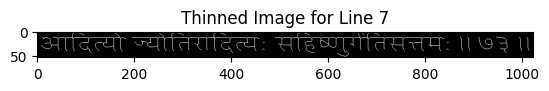

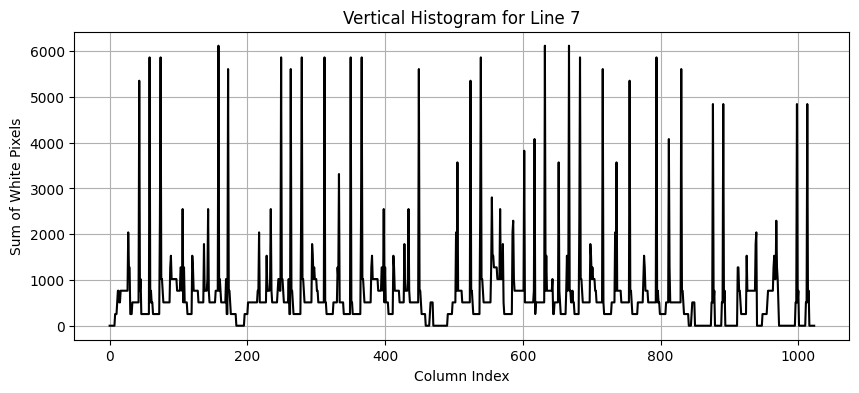

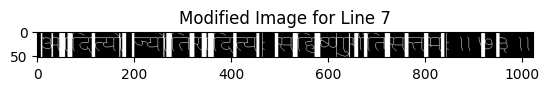

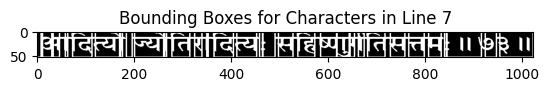

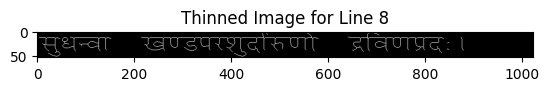

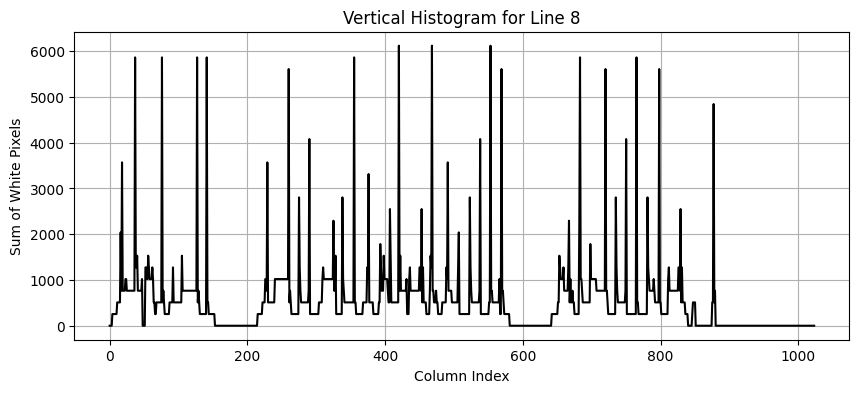

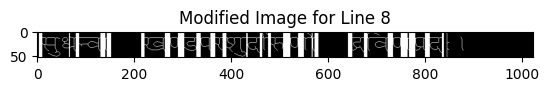

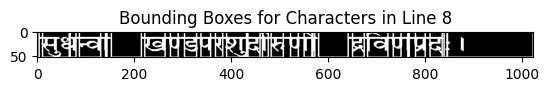

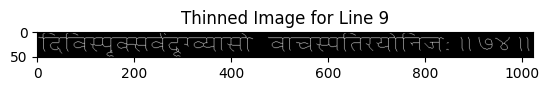

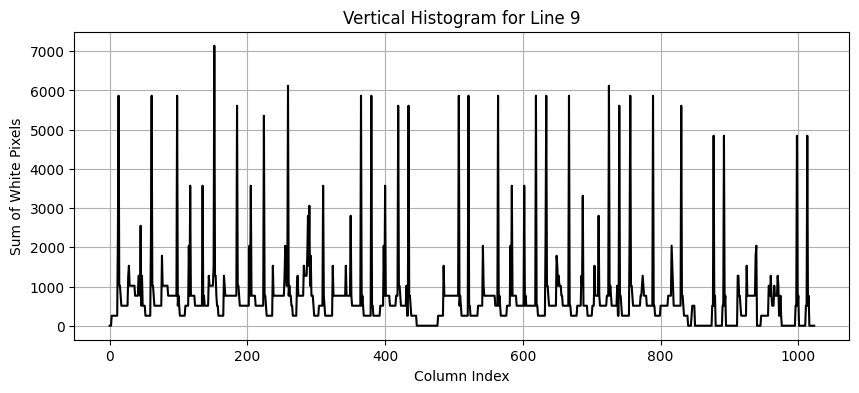

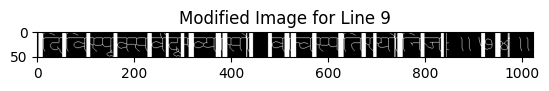

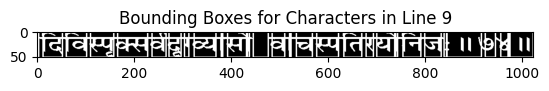

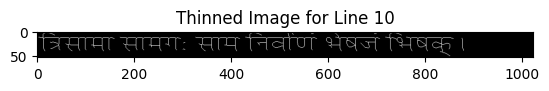

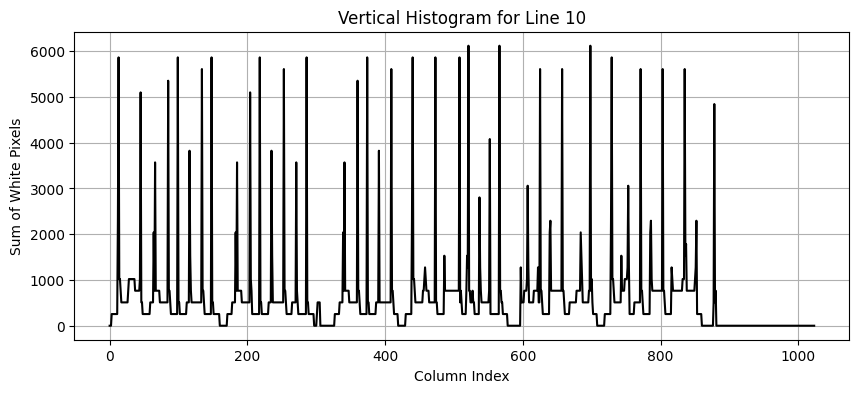

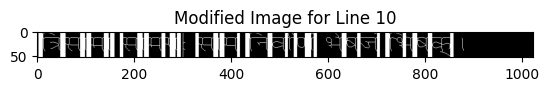

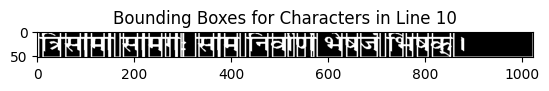

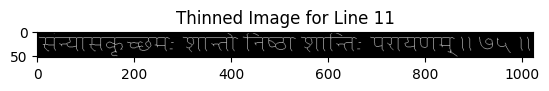

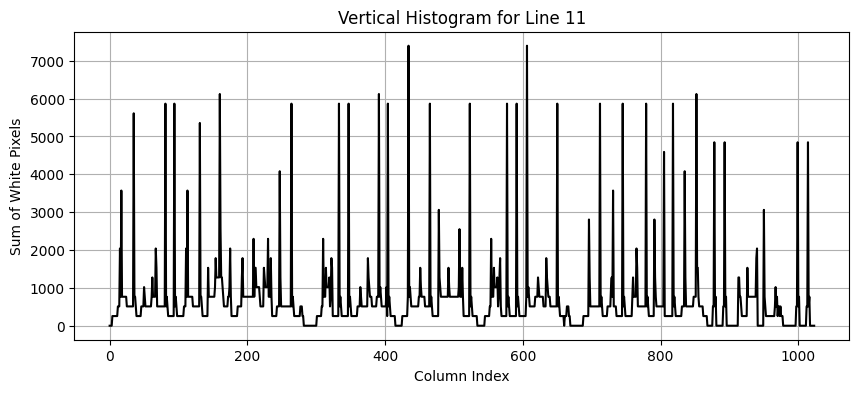

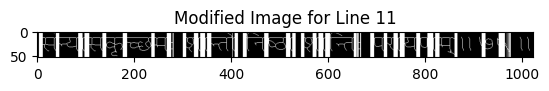

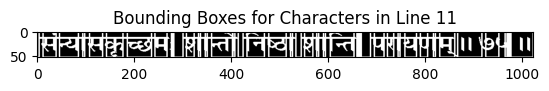

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_ubyte
from skimage.measure import regionprops, label

# Function to perform thinning (skeletonization)
def thin_image(img):
    # Convert to binary image with values 0 and 1
    binary_img = img > 0
    # Perform thinning using skeletonize
    skeleton_img = skeletonize(binary_img)
    # Convert back to 0-255 range
    return img_as_ubyte(skeleton_img)

# Function to count white pixels in each column and replace columns with single white pixel by 1
def process_thinned_image(thinned_img):
    # Count the white pixels in each column
    vertical_hist = np.sum(thinned_img, axis=0)
    
    # Find columns containing a single white pixel
    single_white_pixel_cols = vertical_hist == 255
    
    # Create a new image where columns with single white pixel are replaced by 1
    modified_img = np.copy(thinned_img)
    modified_img[:, single_white_pixel_cols] = 255
    
    return vertical_hist, modified_img

# Function to invert the image and mark bounding boxes
def invert_and_segment_characters(modified_img):
    if modified_img.size == 0:
        raise ValueError("Modified image is empty or not correctly loaded")

    # Invert the image: 255s become 0s (background becomes black), and 0s become 255s (text remains white)
    inverted_img = np.where(modified_img == 255, 0, 255).astype(np.uint8)

    # Label connected components (characters)
    labeled_img = label(inverted_img, connectivity=2)

    # Extract bounding boxes of the connected components
    regions = regionprops(labeled_img)
    bounding_boxes = [(int(region.bbox[0]), int(region.bbox[1]), int(region.bbox[2]), int(region.bbox[3])) for region in regions]

    return inverted_img, bounding_boxes

# Load the image
img_path = '/kaggle/input/sanskrit-model-train/img (103).jpg'  # Update with the correct path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

if img is None:
    raise FileNotFoundError(f"Image not found at {img_path}")

# Verify image dimensions
print(f"Image shape: {img.shape}")

# Apply Otsu's thresholding to binarize the image
_, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Verify binary image dimensions
print(f"Binary image shape: {binary_img.shape}")

# Display the binarized image
plt.imshow(binary_img, cmap='gray')
plt.title('Binarized Image')
plt.show()

# Function to segment lines
def segment_lines(binary_image):
    if binary_image.size == 0:
        raise ValueError("Binary image is empty or not correctly loaded")

    # Construct the horizontal histogram
    horizontal_hist = np.sum(binary_image, axis=1)
    print(f"Horizontal histogram length: {len(horizontal_hist)}")

    # Find rows with no white pixels
    no_white_rows = horizontal_hist == 0
    
    # Invert the image
    inverted_img = np.copy(binary_image)
    inverted_img[no_white_rows] = 0
    inverted_img[~no_white_rows] = 255

    # Label connected components (text lines)
    labeled_img = label(inverted_img, connectivity=2)

    # Extract bounding boxes of the connected components
    regions = regionprops(labeled_img)
    bounding_boxes = [(int(region.bbox[0]), int(region.bbox[1]), int(region.bbox[2]), int(region.bbox[3])) for region in regions]

    return bounding_boxes, inverted_img

# Apply line segmentation
line_bounding_boxes, _ = segment_lines(binary_img)

# Process each line image
if line_bounding_boxes:
    for line_idx, (start, left, end, right) in enumerate(line_bounding_boxes):
        line_img = binary_img[start:end, left:right]

        # Thin the line image
        thinned_img = thin_image(line_img)

        # Display the thinned image
        plt.imshow(thinned_img, cmap='gray')
        plt.title(f'Thinned Image for Line {line_idx + 1}')
        plt.show()

        # Process the thinned image to count white pixels and replace columns with single white pixel
        vertical_hist, modified_img = process_thinned_image(thinned_img)

        # Display the vertical histogram
        plt.figure(figsize=(10, 4))
        plt.plot(vertical_hist, color='black')
        plt.title(f'Vertical Histogram for Line {line_idx + 1}')
        plt.xlabel('Column Index')
        plt.ylabel('Sum of White Pixels')
        plt.grid(True)
        plt.show()

        # Display the modified image
        plt.imshow(modified_img, cmap='gray')
        plt.title(f'Modified Image for Line {line_idx + 1}')
        plt.show()

        # Invert the image and mark bounding boxes for characters
        inverted_img, bounding_boxes = invert_and_segment_characters(modified_img)

        # Display the original line image with bounding boxes
        img_with_boxes = np.copy(line_img)  # Make a copy of the original line image
        for (start, left, end, right) in bounding_boxes:
            cv2.rectangle(img_with_boxes, (left, start), (right, end), (255, 0, 0), 2)

        plt.imshow(img_with_boxes, cmap='gray')
        plt.title(f'Bounding Boxes for Characters in Line {line_idx + 1}')
        plt.show()

else:
    print("No lines detected, so no character segmentation to perform.")
